In [648]:
import torch as t
import torch.functional as F
import os
import os.path as osp
import anndata as ad
import scanpy as sc
import eggplant as eg

from torch.utils.data import Dataset, DataLoader

In [740]:
DATA_DIR = "../data/human-breast-cancer/curated/bcA.h5ad"

adatas = {"bcA":ad.read_h5ad(DATA_DIR)}
key = "bcA"

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [738]:
class AE(t.nn.Module):
    def __init__(self,n_features):
        super().__init__()
        
        self.n_h = 128
        self.n_l = 50
        
        self.n_features = n_features
          
        
        self.input = t.nn.Linear(self.n_features,self.n_h)
        self.eh1 = t.nn.Linear(self.n_h,self.n_l)
        self.dh1 = t.nn.Linear(self.n_l,self.n_h)
        self.output = t.nn.Linear(self.n_h,self.n_features)
                
    def encoder(self,x):
        x = self.input(x)
        x = t.nn.functional.relu(x)
        x = self.eh1(x)
        return x
    
    def decoder(self,x):
        x = self.dh1(x)
        x = t.nn.functional.relu(x)
        x = self.output(x)
        return x
    
    def variance_decoder(self,v):
        with t.no_grad():
            v = v @ (self.dh1.weight.T @ self.output.weight.T) **2
        return v
        
          
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [734]:
class DataSet(Dataset):
    def __init__(self,X):
        self.X = t.tensor(X)
        self.N = X.shape[0]
        self.F = X.shape[1]
        
    def __getitem__(self, idx):
        return self.X[idx,:]
    
    def __len__(self,):
        return self.N

In [741]:
for aa in adatas.values():
    eg.pp.default_normalization(aa)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [743]:
V = np.random.random(adatas[key].shape)
dataset = DataSet(adatas[key].X)
dataloader = DataLoader(dataset,batch_size = dataset.N)

In [744]:
# Model Initialization
model = AE(n_features=dataset.F)
  
# Validation using MSE Loss function
loss_function = t.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = t.optim.Adam(model.parameters(),
                             lr = 1e-3)

In [ ]:
import time

In [745]:
t_start = time.time()
epochs = 1000
outputs = []
losses = []
for epoch in range(epochs):
    for batch in dataloader:
            
        reconstructed = model(batch)

        loss = loss_function(reconstructed,batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

t_end = time.time()
print("Training of AE took: {}s".format(t_end - t_start))

KeyboardInterrupt: 

In [691]:
import matplotlib.pyplot as plt

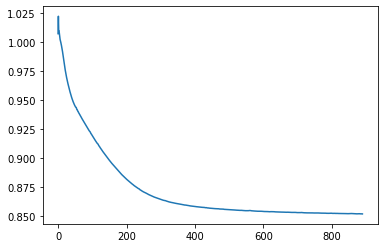

In [747]:
plt.plot(losses)

In [752]:
model.eval()
re = model(dataset.X).detach().numpy()

In [713]:
import numpy as np

In [593]:
import matplotlib.pyplot as plt

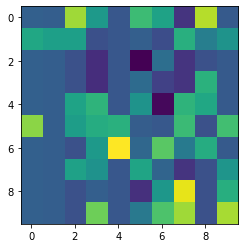

In [753]:
model.eval()
plt.imshow(dataset.X.detach().numpy()[0:10,0:10])
plt.show()

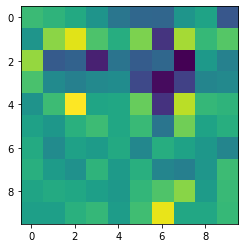

In [754]:
plt.imshow(re[0:10,0:10])
plt.show()

In [450]:
model.variance_decoder(t.tensor(z.astype(np.float32)))

tensor([[ 0.2230,  0.7143,  0.1120,  ...,  0.0689,  0.0919,  0.0332],
        [ 0.3213,  1.0123,  0.1994,  ...,  0.1126,  0.0952,  0.0427],
        [ 0.1704,  1.5333,  0.3273,  ...,  0.0994,  0.0955,  0.0692],
        ...,
        [ 0.3629,  0.3741,  0.0230,  ...,  0.1035,  0.0831,  0.0726],
        [ 0.2049, -0.3231,  0.0959,  ...,  0.0960,  0.1036,  0.0301],
        [ 0.2497, -0.5920,  0.0053,  ...,  0.0854,  0.0707,  0.0485]])

In [639]:
var = np.random.uniform(0,10,size = 10)
means = np.random.uniform(0,5,size = 10)
z = np.random.normal(means,np.sqrt(var), size = (10000,10))

In [640]:
dz = model.decoder(t.tensor(z.astype(np.float32))).detach()
dv = model.variance_decoder(t.tensor(var.astype(np.float32)))

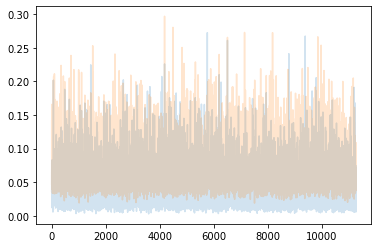

In [697]:
plt.plot(dv,alpha = 0.2)
plt.plot(dz.var(axis=0),alpha=0.2)

In [698]:
sc.pp.pca(adatas["Rep11_MOB"],n_comps=50)

In [699]:
nc = 250
pca_rec = np.dot(adatas["Rep11_MOB"].obsm["X_pca"][:,0:nc],adatas["Rep11_MOB"].varm["PCs"][:,0:nc].T)

In [700]:
rmse_pca = np.sum((pca_rec - adatas["Rep11_MOB"].X)**2)
rmse_ae = np.sum((re - batch.detach().numpy())**2)

In [701]:
rmse_ae / rmse_pca

1.3406208